In [1]:
import warnings

from yellowbrick.cluster import KElbowVisualizer


pal = [(39/255,95/255,153/255),
       (80/255,176/255,220/255),
       (237/255,244/255,248/255),
       (146/255,144/255,142/255),
       (78/255,78/255,80/255),
        (235/255,154/255,88/255),
       (87/255,126/255,130/255)]

import sklearn.cluster
import sklearn_extra.cluster

import matplotlib.colors as mcolors
import umap.umap_ as umap
import phate
import sklearn.cluster
import numpy as np
import argparse
import cv2
from phate import cluster_custom
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import venn


from tqdm import tqdm
import sys
sys.path.append("/Users/rcarlson/Documents/GitHub/lasagna3/snakes")
import mahotas
from ops.imports_ipython import *

import skimage
import umap.umap_ as umap
import stringdb
import pandas as pd

from dask import compute, delayed
from dask.distributed import Client
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import igraph as ig
from sklearn.neighbors import kneighbors_graph

import leidenalg
import gseapy as gp

scaler = StandardScaler()
import magic

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

### ROC curve

In [2]:
### Define true hits

lowhits = ['MAVS', 'DDX58', 'ATP13A1', 'RNF135', 'IRF3', 'IRF2', 'NCOR2', 'IKBKG',
           
           'SLC35A1','GNE','CMAS','ATP2B1','ADNP','LIN37','ACTR6', 'SEC61B',
           'COG7','KLHL15','CAPN15','PIP4K2C','PDS5A',
          'FBXO11','FBXW7','FZR1']


highhits = ['PRDM1', 'STAT3', 
            'PDCD10','MAP2K6','CCNC','MED13','MED24','MED16','BTAF1',
            'ALG1L2','DIS3L','POGZ','VPS11','VPS16','VPS39',
            'SEPHS1','CAB39','MAU2','AKIRIN1',
            'TADA2B','TAF5L','TAF6L',
            'FLCN','RRAGC','LAMTOR2','LAMTOR3','LAMTOR5'
           ]

defined = pd.read_csv('../Data/TableS3.csv')

truehits = lowhits + highhits
nothits = [g for g in defined[~(pd.isnull(defined.mean_transloc_secondary_antibody)) & ~(pd.isnull(defined.mean_transloc_secondary_reporter))].gene_symbol if g not in truehits]

negnothits = defined.loc[(defined.gene_symbol.isin(nothits)) & 
          (defined.mean_transloc_primary < 0)].gene_symbol
negtruehits = defined.loc[(defined.gene_symbol.isin(truehits)) & 
          (defined.mean_transloc_primary < 0)].gene_symbol
posnothits = defined.loc[(defined.gene_symbol.isin(nothits)) & 
          (defined.mean_transloc_primary > 0)].gene_symbol
postruehits = defined.loc[(defined.gene_symbol.isin(truehits)) & 
          (defined.mean_transloc_primary > 0)].gene_symbol

In [15]:
def grp_df(sg_df_loc):
    grped = pd.read_hdf(sg_df_loc)
    nt = grped[grped.gene == "nontargeting"]
    bcls = ([nt.cell_barcode_0[i:i + 3] for i in range(0, len(nt.cell_barcode_0), 3)])
    grped['gene_og'] = grped['gene']
    for i in range(len(bcls)):
        grped.loc[grped.cell_barcode_0.isin(bcls[i]),'gene'] = 'nontargeting_' + str(i)
    grped = grped.groupby(['gene','gene_og']).mean().reset_index()
    grped.reset_index(inplace = True)
    return grped

In [97]:
loc = '../../Zenodo_IRF3/DeepLearning/Transfer/Features/tf_df_feats_ch2_grped_sgonly.hdf'

transfer = grp_df(loc)
transfer = transfer[transfer.gene.isin(truehits + nothits)]
transfer.loc[transfer.gene.isin(nothits),'hit_status'] = 'not hit'
transfer.loc[transfer.gene.isin(negtruehits),'hit_status'] = 'neg'
transfer.loc[transfer.gene.isin(postruehits),'hit_status'] = 'pos'

loc = '../../Zenodo_IRF3/DeepLearning/Autoencoder/Features/ae_df_feats_ch2_grped_sgonly.hdf'

autoencoder = grp_df(loc)
autoencoder = autoencoder[autoencoder.gene.isin(truehits + nothits)]
autoencoder.loc[autoencoder.gene.isin(nothits),'hit_status'] = 'not hit'
autoencoder.loc[autoencoder.gene.isin(negtruehits),'hit_status'] = 'neg'
autoencoder.loc[autoencoder.gene.isin(postruehits),'hit_status'] = 'pos'

defined = defined[defined.gene_symbol.isin(transfer.gene)]
defined.loc[defined.gene_symbol.isin(nothits),'hit_status'] = 'not hit'
defined.loc[defined.gene_symbol.isin(negtruehits),'hit_status'] = 'neg'
defined.loc[defined.gene_symbol.isin(postruehits),'hit_status'] = 'pos'


In [103]:
## Train classifier defined
Xm = np.array(defined[defined.gene_symbol.isin(nothits + truehits)].mean_transloc_primary)[:,np.newaxis]
factor = pd.factorize(defined[defined.gene_symbol.isin(nothits + truehits)].hit_status)
defined['hit_status'] = factor[0]
defined.definitions = factor[1]
ym = defined.hit_status
X_train, X_test, y_train, y_test, gene_train, gene_test = train_test_split(Xm, ym, defined.gene_symbol, test_size=0.3, shuffle=True, 
                                                                           random_state = 8)

rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["defined"] = all_fpr
tpr["defined"] = mean_tpr
roc_auc["defined"] = auc(fpr["defined"], tpr["defined"])

## Train classifier transfer
factor = pd.factorize(transfer[transfer.gene.isin(nothits + truehits)].hit_status)
transfer['hit_status'] = factor[0]
transfertrain = transfer[transfer.gene.isin(gene_train)]
transfertest = transfer[transfer.gene.isin(gene_test)]
X_train = np.array(transfertrain.loc[:, transfer.columns.str.startswith('cnn')])
X_test = np.array(transfertest.loc[:, transfer.columns.str.startswith('cnn')])
y_train = transfertrain.hit_status
y_test = transfertest.hit_status


rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["transfer"] = all_fpr
tpr["transfer"] = mean_tpr
roc_auc["transfer"] = auc(fpr["transfer"], tpr["transfer"])

## Train classifier autoencoder
factor = pd.factorize(autoencoder[autoencoder.gene.isin(nothits + truehits)].hit_status)
autoencoder['hit_status'] = factor[0]
autoencodertrain = autoencoder[autoencoder.gene.isin(gene_train)]
autoencodertest = autoencoder[autoencoder.gene.isin(gene_test)]
X_train = np.array(autoencodertrain.loc[:, autoencoder.columns.str.startswith('ae')])
X_test = np.array(autoencodertest.loc[:, autoencoder.columns.str.startswith('ae')])
y_train = autoencodertrain.hit_status
y_test = autoencodertest.hit_status


rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["autoencoder"] = all_fpr
tpr["autoencoder"] = mean_tpr
roc_auc["autoencoder"] = auc(fpr["autoencoder"], tpr["autoencoder"])

## Train classifier combined

cnnmean = transfer.loc[:,transfer.columns.str.contains('feat')].mean(axis = 0).mean()
aemean = autoencoder.loc[:,autoencoder.columns.str.contains('feat')].mean(axis = 0).mean()
combined = pd.merge(transfer, autoencoder,on = 'gene')



factor = pd.factorize(combined[combined.gene.isin(nothits + truehits)].hit_status_x)
combined['hit_status'] = factor[0]
combinedtrain = combined[combined.gene.isin(gene_train)]
combinedtest = combined[combined.gene.isin(gene_test)]
X_train = np.array(combinedtrain.loc[:, combined.columns.str.contains('feat')])
X_test = np.array(combinedtest.loc[:, combined.columns.str.contains('feat')])
y_train = combinedtrain.hit_status
y_test = combinedtest.hit_status


rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["combined"] = all_fpr
tpr["combined"] = mean_tpr
roc_auc["combined"] = auc(fpr["combined"], tpr["combined"])

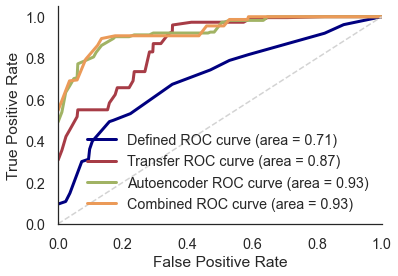

In [122]:
# Plot all ROC curves
lw = 3
sns.set(font_scale=1.3)
sns.set_style('white')


plt.figure(figsize = (5.8,4))

plt.plot(fpr["defined"], tpr["defined"],
         label='Defined ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["defined"]),
         color='navy', linewidth=lw)

plt.plot(fpr["transfer"], tpr["transfer"],
         label='Transfer ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["transfer"]),
         color=pal[0], linewidth=lw)

plt.plot(fpr["autoencoder"], tpr["autoencoder"],
         label='Autoencoder ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["autoencoder"]),
         color=pal[2], linewidth=lw)

plt.plot(fpr["combined"], tpr["combined"],
         label='Combined ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["combined"]),
         color=pal[4], linewidth=lw)

    
plt.plot([0, 1], [0, 1], 'lightgray', linestyle =  '--', lw=lw*.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
sns.despine(top = True, right = True)

plt.savefig('rf.tif',dpi=600,bbox_inches = 'tight')
plt.show()

### IRF3 Translocation Barplot

In [72]:

df = pd.read_hdf('../Data/F3/m157-158.hdf')

ctrls =  ['nontargeting', 'DDX58', 'MAVS']
sorter = ctrls + list(df[~df.gene.isin(ctrls)].groupby('gene').dapi_gfp_corr_nuclear.mean().sort_values().index)
df.gene = df.gene.astype('category')

df.gene.cat.set_categories(sorter, inplace=True)
df = df.sort_values(["gene"])
df.gene = df.gene.astype('string')
df.loc[df.sgRNA.str.endswith('_2'),'sgRNA'] = [s.split('_2')[0] + '_0' for s in df[df.sgRNA.str.endswith('_2')].sgRNA]


#

4816579
gate applied, retained  73 % of data
number nt 6000
dapi_gfp_corr_nuclear
auc done
            gene  n_sg  fisher_combined_chi          pval  fdr_bh_adj_p  \
0   nontargeting   2.0             1.871671  7.593470e-01  7.593470e-01   
1          DDX58   2.0            92.854369  3.258047e-19  5.538679e-18   
2           MAVS   2.0            85.046191  1.483112e-17  1.260645e-16   
3           PPA2   2.0            57.680281  8.906086e-12  5.046782e-11   
4         FAM98B   2.0            34.099236  7.110710e-07  3.022052e-06   
5           COA5   2.0            30.950538  3.133348e-06  1.065338e-05   
6        ANKRD63   2.0            24.075549  7.713729e-05  1.962939e-04   
7           GCAT   2.0            18.060935  1.200712e-03  2.551513e-03   
8          TIPRL   2.0            23.974324  8.082691e-05  1.962939e-04   
9       MTRNR2L4   2.0            15.205546  4.293349e-03  8.109659e-03   
10       PLEKHB1   2.0            13.195779  1.035776e-02  1.760819e-02   
11       

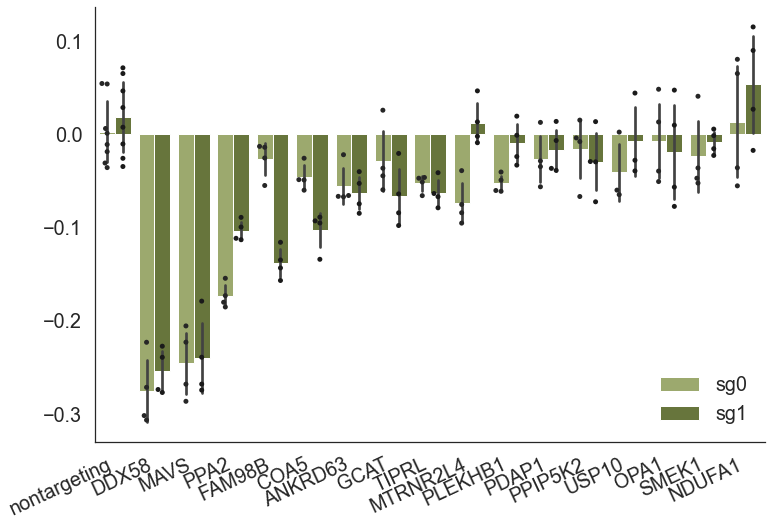

In [76]:
from ops.firedove_barplots import *
aucs, grped = produce_barplot_general(df,  df_name = 'm157-8', pshow = True, 
                                    genes = pd.unique(df.gene),
            gate = '100 < i <1380 & 100 < j < 1380 & area <= 300 & area > 10 & dapi_max_nuclear < 20000',
                    replist = [1,2,3,4],  nbins=50,  
                        feature='dapi_gfp_corr_nuclear', plot_nt = False, range_vals = (-1,.7), pal = 'green',
                   alpha=.05, pval_sort = True)

##

### Pex volcano plot

In [2]:
xls = pd.ExcelFile('../Data/TableS4.xls')
df = pd.read_excel(xls, 'Pex_cell_max')
df.index = df.gene_symbol

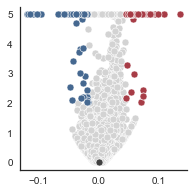

In [9]:
fdrthresh = .01
topn = 50
sns.set_style('white')
pexdowngenesvolcano = (df.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
pexupgenesvolcano = (df.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(x = df['mean'], y = -np.log10(df.fdr_bh_adj_p), color=mcolors.to_rgba('#d3d3d3'))
sns.scatterplot(x = df[df.index == "nontargeting"]['mean'], y = -np.log10(df[df.index== "nontargeting"].fdr_bh_adj_p), 
                color = mcolors.to_rgba('#404040'))
sns.scatterplot(x = df[df.index.isin(pexdowngenesvolcano)]['mean'], 
                y = -np.log10(df[df.index.isin(pexdowngenesvolcano)].fdr_bh_adj_p), color = pal[1])
sns.scatterplot(x = df[df.index.isin(pexupgenesvolcano)]['mean'], 
                y = -np.log10(df[df.index.isin(pexupgenesvolcano)].fdr_bh_adj_p), color = pal[0])

sns.despine(top = True, right = True)
plt.xlabel('')
plt.ylabel('')
plt.savefig('../../../IRF3 Paper/Figures/F3/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

### Pex Gene Ontology

##### Define functions

In [ ]:
def calc_phate(df, colstart):
    phate_op = phate.PHATE(n_components = 10, n_jobs = -1, random_state = 7, knn = 5, t = 10, gamma = 0) 
    dfphate = phate_op.fit_transform(df.loc[:,df.columns.str.startswith(colstart)])
    return dfphate, phate_op

def plot_phate_enrichr_definedgenes(loc, dfphate, geneslow, geneshigh, name):

    grped = grp_df(loc)
    dfu = pd.concat([pd.DataFrame(dfphate[:,:2]),grped],axis = 1)
    dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 

    plt.figure(figsize = (6,6))
    sns.scatterplot(data = dfu, x = 'UMAP1', 
                        y = 'UMAP2', color = mcolors.to_rgba('#d3d3d3'))
   
    sns.scatterplot(data = dfu[dfu.gene.isin(geneslow)], x = 'UMAP1', 
                        y = 'UMAP2', color = pal[1])
    sns.scatterplot(data = dfu[dfu.gene.isin(geneshigh)], x = 'UMAP1', 
                        y = 'UMAP2', color = pal[0])
    sns.scatterplot(data = dfu.query('gene_og == "nontargeting"'), x = 'UMAP1', 
                        y = 'UMAP2',
                    color = mcolors.to_rgba('#404040'))
    sns.despine(top = True, right = True)
    plt.show()

    ##
    i = 0
    fnames = ['low', 'high']
    for genes in [geneslow, geneshigh]:
        k = fnames[i]
        i += 1
        #genes = list(dfu[dfu.cluster == k].gene)
        enr = gp.enrichr(gene_list=list(pd.unique(genes)),
                         gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                                   'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                         organism='Human', 
                         outdir='../Data/F3/enrichrterms/%s_phate_enrichr_%s'%(name,k),
                         cutoff=0.05)
        
    return dfu

##### Find genes different from NT

In [ ]:
loc = '../../Zenodo_IRF3/DeepLearning/Transfer/Features/tf_df_feats_ch6_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_pex_tf, gop_pex_tf = calc_phate(grped, colstart = 'cnn')

loc = '../../Zenodo_IRF3/DeepLearning/Autoencoder/Features/ae_df_feats_ch6_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_pex_ae, gop_pex_ae = calc_phate(grped, colstart = 'ae')

Calculating PHATE...
  Running PHATE on 19943 observations and 1228 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 13.90 seconds.
    Calculating affinities...
    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 16.32 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.35 seconds.
    Calculating KMeans...
    Calculated KMeans in 25.92 seconds.
  Calculated landmark operator in 30.57 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.58 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 163.15 seconds.
Calculated PHATE in 210.63 seconds.
Calculating PHATE...
  Running PHATE on 19943 observations and 1027 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.71 seconds.
    Calculating KNN se

In [ ]:
loc = '../../Zenodo_IRF3/DeepLearning/Transfer/Features/tf_df_feats_ch6_grped_sgonly.hdf'
topn = 50
meanthresh = 0.04
colstart = 'cnn'
grped = grp_df(loc)
dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped,pd.DataFrame(gop_pex_tf.diff_potential)],axis = 1)
dfu.columns = ['PHATE1','PHATE2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_tf.diff_potential.shape[1]))

nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

tfup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
tfdown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

gpex_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_tf, name = 'pex_transfer',
                                                      geneslow = tfdown, geneshigh = tfup)

In [ ]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
topn = 50
meanthresh = 0.04
colstart = 'ae'
grped = grp_df(loc)
\dfu = pd.concat([pd.DataFrame(gphate_pex_ae[:,:2]),grped,pd.DataFrame(gop_pex_ae.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_ae.diff_potential.shape[1]))

nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

aeup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
aedown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
gpex_aeu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_ae, name = 'pex_autoencoder',
                                                      geneslow = aedown, geneshigh = aeup)

##### Plot figure

In [ ]:
sns.set(font_scale=1.2) 
sns.set_style("white")
plt.figure(figsize = (6.5,3))
names = ['Defined down', 'Defined up', 'Autoencoder down', 'Autoencoder up', 'Transfer down', 'Transfer up']
locs = ['../Data/F3/enrichr_pex_max_down_fdr01_top50/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichr_pex_max_up_fdr01_top50/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrmixed/pex_ae_defined_phate_defined_enrichr_cluster_low/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrmixed/pex_ae_defined_phate_defined_enrichr_cluster_high/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrmixed/pex_tf_defined_phate_defined_enrichr_cluster_low/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrmixed/pex_tf_defined_phate_defined_enrichr_cluster_high/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       ]


results = []
for i in range(len(locs)):
    
    res = pd.read_table(locs[i])
    res['Dataset'] = names[i]
    results.append(res)
results = pd.concat(results)
pex = results[results.Term.str.contains('GO:0005777')]
pexsmall = pex.loc[pex.Dataset == 'Autoencoder down']
pexsmall['Dataset'] = 'Autoencoder up'
pexsmall['Adjusted P-value'] = 1
pex = pd.concat([pex,pexsmall])

pex = pd.concat([pex, pexheme])

fig, ax = plt.subplots()
fig.set_size_inches(3,4)

pex.Term = [s.split(' ')[0] for s in pex.Term]
sns.barplot(data = pex, y = 'Dataset', x = -np.log10(pex['Adjusted P-value']), palette = pal[3:], hue = 'Term',
           order = ['Defined down', 'Transfer down', 'Autoencoder down',
                   'Defined up', 'Transfer up', 'Autoencoder up'])#'Combined Score')
sns.despine(top = True, right = True)
plt.ylabel('')
plt.xlabel('')
labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['Defined', 'Transfer', 'Autoencoder','Defined', 'Transfer', 'Autoencoder']

ax.set_yticklabels(labels)
plt.legend(frameon = False, loc = 'lower right')
plt.savefig('../Figures/F3/pex_barplot.tif',dpi=300,bbox_inches='tight')
plt.show()

### SeV volcano plot

In [12]:
xls = pd.ExcelFile('../Data/TableS4.xls')
df = pd.read_excel(xls, 'SeV_cell_median')
df.index = df.gene_symbol

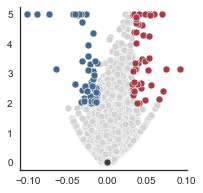

In [13]:
fdrthresh = .01
topn = 50
sns.set_style('white')
pexdowngenesvolcano = (df.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
pexupgenesvolcano = (df.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(x = df['mean'], y = -np.log10(df.fdr_bh_adj_p), color=mcolors.to_rgba('#d3d3d3'))
sns.scatterplot(x = df[df.index == "nontargeting"]['mean'], y = -np.log10(df[df.index== "nontargeting"].fdr_bh_adj_p), 
                color = mcolors.to_rgba('#404040'))
sns.scatterplot(x = df[df.index.isin(pexdowngenesvolcano)]['mean'], 
                y = -np.log10(df[df.index.isin(pexdowngenesvolcano)].fdr_bh_adj_p), color = pal[1])
sns.scatterplot(x = df[df.index.isin(pexupgenesvolcano)]['mean'], 
                y = -np.log10(df[df.index.isin(pexupgenesvolcano)].fdr_bh_adj_p), color = pal[0])

sns.despine(top = True, right = True)
plt.xlabel('')
plt.ylabel('')
plt.savefig('../../../IRF3 Paper/Figures/F3/volcano_sev_cell_median.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

### SeV Gene Ontology

### pex

In [4]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch6_grped_sgonly_goodcells.hdf'
grped = grp_df(loc)
gphate_pex_tf, gop_pex_tf = calc_phate(grped, colstart = 'cnn')
gumap_pex_tf = calc_umap(grped, colstart = 'cnn')

Calculating PHATE...
  Running PHATE on 19239 observations and 1228 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.28 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.30 seconds.
    Calculating affinities...
    Calculated affinities in 0.20 seconds.
  Calculated graph and diffusion operator in 12.87 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.82 seconds.
    Calculating KMeans...
    Calculated KMeans in 23.71 seconds.
  Calculated landmark operator in 27.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.56 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 227.17 seconds.
Calculated PHATE in 267.69 seconds.


In [5]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
grped = grp_df(loc)
gphate_pex_ae, gop_pex_ae = calc_phate(grped, colstart = 'ae')
gumap_pex_ae = calc_umap(grped, colstart = 'ae')

Calculating PHATE...
  Running PHATE on 19239 observations and 1027 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 15.95 seconds.
    Calculating affinities...
    Calculated affinities in 0.73 seconds.
  Calculated graph and diffusion operator in 18.36 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.41 seconds.
    Calculating KMeans...
    Calculated KMeans in 22.48 seconds.
  Calculated landmark operator in 26.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.52 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 112.29 seconds.
Calculated PHATE in 157.82 seconds.


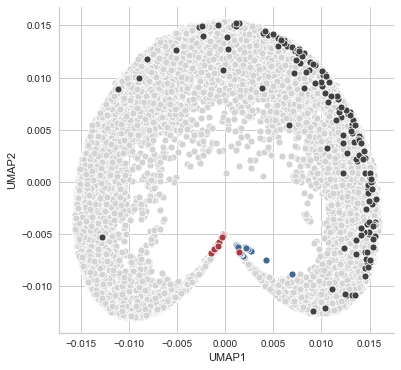

In [8]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch6_grped_sgonly_goodcells.hdf'
topn = 50
meanthresh = 0.04
colstart = 'cnn'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped,pd.DataFrame(gop_pex_tf.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_tf.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

tfup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
tfdown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-transfer/tf_df_feats_ch6_grped_sgonly_goodcells.hdf'
gpex_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_tf, name = 'pex_tf_defined',
                                                      geneslow = tfdown, geneshigh = tfup)

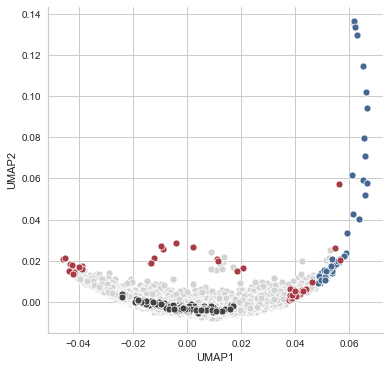

In [9]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'

## before: 25, .2
topn = 50
meanthresh = 0.04
colstart = 'phate'
grped = grp_df(loc)
#grped.loc[:,grped.columns.str.startswith(colstart)] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.startswith(colstart)])
dfu = pd.concat([pd.DataFrame(gphate_pex_ae[:,:2]),grped,pd.DataFrame(gop_pex_ae.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_ae.diff_potential.shape[1]))

nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

aeup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
aedown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
gpex_aeu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_ae, name = 'pex_ae_defined',
                                                      geneslow = aedown, geneshigh = aeup)

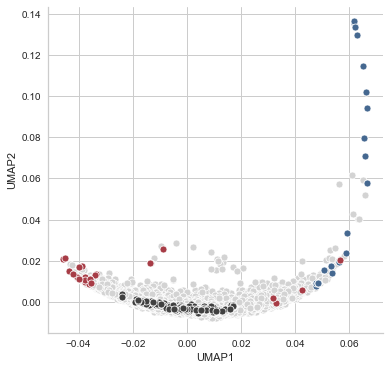

In [355]:
# loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
# topn = 25
# meanthresh = .2
# colstart = 'phate'
# grped = grp_df(loc)
# #grped.loc[:,grped.columns.str.startswith(colstart)] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.startswith(colstart)])
# dfu = pd.concat([pd.DataFrame(gphate_pex_ae[:,:2]),grped,pd.DataFrame(gop_pex_ae.diff_potential)],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_ae.diff_potential.shape[1]))

# nt = dfu.loc[(dfu.gene_og == "nontargeting"),
#                   dfu.columns.str.startswith(colstart)].mean()

# dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

# aeup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
# aedown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

# #

# loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
# gpex_aeu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_ae, name = 'pex_ae_defined',
#                                                       geneslow = aedown, geneshigh = aeup)

In [15]:
pexupgenesvolcano

Index(['GPR17', 'ELP4', 'MPI', 'PLEKHM2', 'ATP6AP2', 'WDYHV1', 'YEATS4',
       'PPIL3', 'PAPD7', 'PPCDC', 'EPC2', 'TIPRL', 'UBA5', 'IL22', 'PINX1',
       'GPR61', 'CRKL', 'UFSP2', 'NMNAT1', 'FASTKD5', 'ELP2', 'SIAH2',
       'VPS13D', 'UFL1', 'TMEM135', 'VAPA', 'UFM1', 'RBM15', 'SEM1', 'IKBKAP',
       'SLC4A7', 'CNOT9', 'DDX1', 'AHCYL1', 'ATAD1', 'UFC1', 'UBE2K',
       'ZCCHC11', 'UROS', 'PPCS', 'DNAJC8', 'SPEN', 'MCTS1', 'SAMD4B', 'PCYT2',
       'IDE', 'FEN1', 'MFF', 'DENR', 'ABCD3'],
      dtype='object', name='gene_symbol')

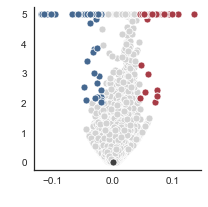

In [19]:
fdrthresh = .01
#meanthresh = .15
# meanthresh2 = 2*meanthresh
topn = 50
sns.set_style('white')
sev = pd.read_pickle('../Data/m40-m42/pex_max_volcano.pkl')
#sev = sev[sev.index.isin(grped.gene_og)] ### for comparison
#grped_pex_max.pkl')
sev['mean'] =  sev['mean']
pexdowngenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
pexupgenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(sev['mean'], -np.log10(sev.fdr_bh_adj_p), c=mcolors.to_rgba('#d3d3d3'))
#sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index == "nontargeting"]['mean'], -np.log10(sev[sev.index== "nontargeting"].fdr_bh_adj_p), 
                c = mcolors.to_rgba('#404040'))
# sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index.isin(pexdowngenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(pexdowngenesvolcano)].fdr_bh_adj_p), c = pal[1])
sns.scatterplot(sev[sev.index.isin(pexupgenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(pexupgenesvolcano)].fdr_bh_adj_p), c = pal[0])
# sns.scatterplot(sev[sev.index.isin(pexdowngenestf)]['mean'], 
#                 -np.log10(sev[sev.index.isin(pexdowngenestf)].fdr_bh_adj_p), c = pal[2])

sns.despine(top = True, right = True)
plt.xlabel(' ')
plt.ylabel(' ')
plt.savefig('../Figures/m40-42_transfer/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

In [25]:
(sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean'))[:10]

,mean,n_sg,fisher_combined_chi,2_sided_p_value,fdr_bh_adj_p,significant
gene_symbol,,,,,,
ADSS,-0.118418,1.0,inf,0.0,0.00001,True
PEX13,-0.117061,4.0,inf,0.0,0.00001,True
PEX2,-0.114550,4.0,inf,0.0,0.00001,True
PEX14,-0.108918,3.0,inf,0.0,0.00001,True
PEX1,-0.104314,4.0,inf,0.0,0.00001,True
ZCCHC14,-0.103306,3.0,inf,0.0,0.00001,True
PEX12,-0.099947,4.0,inf,0.0,0.00001,True
PEX10,-0.096366,4.0,inf,0.0,0.00001,True
PEX6,-0.095269,4.0,inf,0.0,0.00001,True


In [22]:
pexdowngenesvolcano

Index(['ADSS', 'PEX13', 'PEX2', 'PEX14', 'PEX1', 'ZCCHC14', 'PEX12', 'PEX10',
       'PEX6', 'PEX5', 'PEX26', 'PEX11B', 'VHL', 'PEX3', 'PEX11A', 'KRTAP5-11',
       'PPRC1', 'GOLGA6L10', 'CDK13', 'SLTM', 'KEAP1', 'ZBTB17', 'UBE2D3',
       'SGF29', 'SEPHS1', 'UBAP2L', 'INPP5K', 'C19orf43', 'TASP1', 'DHX29',
       'RBM12', 'MED23', 'JUNB', 'SDR42E1', 'SIN3B', 'CHD1', 'PAPD5', 'SCAF8',
       'PEX19', 'SLC27A2', 'SAFB', 'MED16', 'IVD', 'PRUNE1', 'FAF2', 'CPSF7',
       'INTS12', 'FIS1', 'ASB7', 'GIPC1'],
      dtype='object', name='gene_symbol')

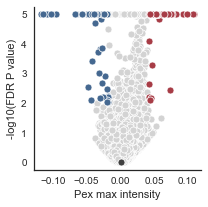

In [26]:
fdrthresh = .01
#meanthresh = .15
# meanthresh2 = 2*meanthresh
topn = 50
sns.set_style('white')
sev = pd.read_pickle('../Data/m40-m42/pex_max_volcano.pkl')
sev = sev[sev.index.isin(grped.gene_og)] ### for comparison
#grped_pex_max.pkl')
sev['mean'] =  sev['mean']
pexdowngenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
pexupgenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(sev['mean'], -np.log10(sev.fdr_bh_adj_p), c=mcolors.to_rgba('#d3d3d3'))
#sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index == "nontargeting"]['mean'], -np.log10(sev[sev.index== "nontargeting"].fdr_bh_adj_p), 
                c = mcolors.to_rgba('#404040'))
# sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index.isin(pexdowngenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(pexdowngenesvolcano)].fdr_bh_adj_p), c = pal[1])
sns.scatterplot(sev[sev.index.isin(pexupgenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(pexupgenesvolcano)].fdr_bh_adj_p), c = pal[0])
# sns.scatterplot(sev[sev.index.isin(pexdowngenestf)]['mean'], 
#                 -np.log10(sev[sev.index.isin(pexdowngenestf)].fdr_bh_adj_p), c = pal[2])

sns.despine(top = True, right = True)
plt.xlabel('Pex max intensity')
plt.ylabel('-log10(FDR P value)')
#plt.savefig('../Figures/m40-42_transfer/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

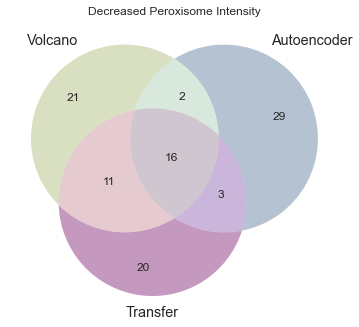

In [27]:
venn3([set(pexdowngenesvolcano), set(aedown), set(tfdown)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Decreased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_pex_max_down_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

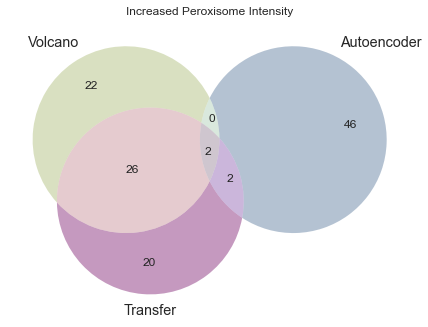

In [521]:
venn3([set(pexupgenesvolcano), set(aeup), set(tfup)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Increased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_pex_max_up_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

In [522]:
[print(p) for p in list(set(pexdowngenesvolcano) & set(tfdown) & set(aedown))]

PEX3
PEX10
SEPHS1
SLTM
PEX2
PEX26
ZCCHC14
PEX13
PEX6
TASP1
PEX1
PEX5
VHL
PEX12
PEX14
PEX11B


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [505]:
[print(p) for p in list(aeup) if p not in list(set(pexupgenesvolcano) & set(tfup))]

FAF2
SLC33A1
NUTM2G
ITGB5
GNE
DDX46
LOC107987125
RFWD2
SLC35A1
ATP2C1
FBXO11
ATP2B1
KLC3
FBXW7
LIMS1
OGDH
PPOX
DET1
TEX10
CHURC1
RIC8A
SLC35B2
KIAA0391
GRN
DHX8
TOR4A
CCL13
MIOS
PLA2R1
COQ4
NDST2
CD68
GTF2E1
LOC101060022
NENF
ARPC3
BRD2
CCDC189


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [28]:


# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=pd.Series(list(pexdowngenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/m40-m42/enrichr_pex_max_down_fdr01_top50',
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )



# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=pd.Series(list(pexupgenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/m40-m42/enrichr_pex_max_up_fdr01_top50',
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )



### sev

In [363]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch4_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_sev_tf, gop_sev_tf = calc_phate(grped, colstart = 'cnn')
gumap_sev_tf = calc_umap(grped, colstart = 'cnn')

Calculating PHATE...
  Running PHATE on 19076 observations and 1240 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.89 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.28 seconds.
  Calculated graph and diffusion operator in 12.24 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.80 seconds.
    Calculating KMeans...
    Calculated KMeans in 19.01 seconds.
  Calculated landmark operator in 22.41 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.57 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 150.30 seconds.
Calculated PHATE in 185.65 seconds.


In [362]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch4_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_sev_ae, gop_sev_ae = calc_phate(grped, colstart = 'ae')
gumap_sev_ae = calc_umap(grped, colstart = 'ae')

Calculating PHATE...
  Running PHATE on 19076 observations and 1039 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.65 seconds.
    Calculating KNN search...
    Calculated KNN search in 23.99 seconds.
    Calculating affinities...
    Calculated affinities in 1.14 seconds.
  Calculated graph and diffusion operator in 26.94 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.94 seconds.
    Calculating KMeans...
    Calculated KMeans in 27.03 seconds.
  Calculated landmark operator in 31.87 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.77 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 112.27 seconds.
Calculated PHATE in 171.91 seconds.


In [534]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch4_grped_sgonly.hdf'
topn = 40
meanthresh = .04
colstart = 'cnn'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_sev_tf[:,:2]),grped,pd.DataFrame(gop_sev_tf.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_sev_tf.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

In [543]:
topn = 30
meanthresh = .04

#tmp = dfu.query('sev_cell_median > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn]
tmp = dfu.query('(sev_cell_median < - @meanthresh) | (sev_cell_median > @meanthresh)')[['gene','distance','sev_cell_median']].sort_values(['distance'], ascending=False)[:topn]

tmp[tmp.gene.isin(['NUP155','SART1','USP39','CCAR1','PRPF31'])]

##

,gene,distance,sev_cell_median
11241,NUP155,2.582031,-0.146038
17716,USP39,2.064453,0.294107
13068,PRPF31,1.918945,-0.091632
14274,SART1,1.848633,-0.049417


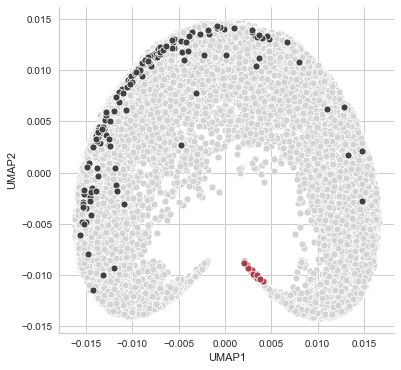

In [544]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch4_grped_sgonly.hdf'
topn = 30
meanthresh = .04
colstart = 'cnn'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_sev_tf[:,:2]),grped,pd.DataFrame(gop_sev_tf.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_sev_tf.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

#tfup=dfu.query('sev_cell_median > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
#tfdown=dfu.query('sev_cell_median < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
tfdown=dfu.query('(sev_cell_median < - @meanthresh) | (sev_cell_median > @meanthresh)')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-transfer/tf_df_feats_ch4_grped_sgonly.hdf'
gpex_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_sev_tf, name = 'sev_tf_defined',
                                                      geneslow = tfdown, geneshigh = tfdown)